**A magician and a pendulum**

You are a magician and you have a hanging pendulum. You can exert force to the pendulum, but remember that your magic power is limited.

Given the initial position and velocity of the pendulum, your mission is the same : make the position and velocity 0 simultaneously and minimize the stopping time.

**Question 2.**

* We have a priori bang-bang assumption.
* We only know **the governing equation** of the pendulum.
* We do not know how to minimize the stopping time.
* We know machine learning.


Q. Do the same as in **Question 1**, except that you must simulate the behavior of the pendulum by Runge-Kutta 4 method.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

**Mass-Spring-Damper model (with no externel force):**
 $ \large m\ddot \theta + \lambda \dot \theta + \omega^2 \theta = 0$
* $m=1$, $\lambda < 2 \omega $
* $\theta (0) = \theta_1, \dot\theta(0) = \theta_2 $

In [2]:
class PendulumEnv:
    
    def __init__(self, lambda_val=0.5, omega=1.0, dt=0.05):
        
        self.lambda_val = lambda_val
        self.omega = omega
        self.dt = dt

    def dynamics(self, state, control):

        theta, theta_dot = state
        alpha = control

        d_theta = theta_dot
        d_theta_dot = -self.lambda_val * theta_dot - self.omega**2 * theta + alpha

        return np.array([d_theta, d_theta_dot])
    
    def rk4(self, state, control):

        k1 = self.dynamics(state, control)
        k2 = self.dynamics(state + 0.5 * self.dt * k1, control)
        k3 = self.dynamics(state + 0.5 * self.dt * k2, control)
        k4 = self.dynamics(state + self.dt * k3, control)

        next_state = state + (self.dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        
        return next_state

In [3]:
class Control(nn.Module):

    def __init__(self):
        super(Control, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    
    def forward(self, x):
        return self.net(x)

# Time-Optimal Control with REINFORCE

## 1. System Dynamics
시스템의 상태(State)는 각도 $\theta$와 각속도 $\dot{\theta}$로 정의되며, **RK4 (Runge-Kutta 4th Order)** 적분기를 사용하여 시뮬레이션합니다.

- **State Space:** $s_t = [\theta_t, \dot{\theta}_t]^T$
- **Action Space:** $a_t \in \{0, 1\} \rightarrow u_t \in \{-1, 1\}$ (Discrete Force)
- **Initialization:**
    - $\theta_{init} \sim \mathcal{U}(-2, 2)$
    - $\dot{\theta}_{init} \sim \mathcal{U}(-1, 1)$

## 2. Training Configuration

### Hyperparameters
| Parameter | Value | Description |
| :--- | :--- | :--- |
| **Algorithm** | REINFORCE | with Return Normalization |
| **Optimizer** | Adam | Learning Rate $\alpha = 0.01$ |
| **Discount Factor ($\gamma$)** | $0.99$ | Future reward decay |
| **Total Epochs** | $1000$ | Number of episodes |
| **Max Steps ($T$)** | $1000$ | Max duration per episode ($50s$) |

## 3. Reward Function Design
**최단 시간 제어(Time Optimal Control)** 목적 달성을 위해, 불필요한 움직임(시간 소모)에 대해 페널티를 부여하고 성공 시 큰 보상을 제공하는 구조로 설계되었습니다.

매 스텝($t$) 보상 $R_t$는 다음과 같이 구성됩니다.

### **(1) Step Penalty (Time Cost)**
$$r_{step} = -1.0$$
* 에이전트가 목표에 도달하지 못하고 시간을 소비하는 매 순간마다 고정 페널티를 부여하여, **가장 빠른 경로**를 찾도록 유도합니다.

### **(2) Distance Shaping**
$$r_{shape} = -0.1 \cdot |\theta_t|$$
* 속도($\dot{\theta}$) 항을 제외하고 위치($\theta$) 오차만 반영하여, 에이전트가 **가속을 두려워하지 않고** 원점 방향으로 접근하도록 가이드합니다.

### **(3) Terminal Rewards (Override)**
에피소드 종료 조건 달성 시, 해당 스텝의 보상은 아래 값으로 덮어쓰기(Override) 됩니다.

* **Success (Goal Reached):** $\mathbf{+100.0}$
    * Condition: $|\theta_t| < 0.05$ **and** $|\dot{\theta}_t| < 0.2$
    * 위치와 속도가 모두 안정화되었을 때 성공으로 간주합니다.
* **Failure (Early Stopping):** $\mathbf{-500.0}$
    * Condition: $|\theta_t| > 3.0$ **or** $|\dot{\theta}_t| > 10.0$
    * 상태가 발산하거나 제어 불가능한 영역으로 벗어날 경우 큰 페널티를 부여하고 종료합니다.

## 4. Algorithm Details
학습의 안정성을 높이기 위해 **Return Normalization** 기법을 적용하였습니다.

$$G_t = \sum_{k=0}^{T-t-1} \gamma^k r_{t+k}$$
$$G_{norm} = \frac{G - \mu_G}{\sigma_G + \epsilon}$$

정규화된 반환값 $G_{norm}$을 사용하여 Policy Gradient를 계산합니다.
$$\nabla J(\theta) \approx \sum_{t=0}^{T-1} \nabla_\theta \log \pi_\theta(a_t | s_t) \cdot G_{norm, t}$$

In [4]:
def PendulumStopping():
    env = PendulumEnv()
    model = Control()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    angle = np.random.uniform(-2,2)
    velocity = np.random.uniform(-1,1)

    initial_state = np.array([angle, velocity])

    epochs = 1000
    gamma = 0.99

    loss_history = []

    print(f"Training started...")

    for epoch in range(epochs):
        state = initial_state
        log_probs = []
        rewards = []

        for t in range(1000):

            state_tensor = torch.FloatTensor(state)
            logits = model(state_tensor)

            probs = torch.softmax(logits, dim = 0)
            dist = torch.distributions.Categorical(probs)
            action_idx = dist.sample()

            log_prob = dist.log_prob(action_idx)

            alpha = -1.0 if action_idx.item()==0 else 1.0

            next_state = env.rk4(state, alpha)

            theta, theta_dot = next_state
            reward = - 1.0 # time penalty
            reward -= 0.1* abs(theta)

            done = False

            if abs(theta) < 0.05 and abs(theta_dot) < 0.2:
                reward = 100.0
                done = True
            
            elif abs(theta) > 3.0 or abs(theta_dot) > 10.0:
                reward = -500
                done = True

            log_probs.append(log_prob)
            rewards.append(reward)
            state = next_state

            if done:
                break

        R = 0
        policy_loss = []
        returns = []
        for r in rewards[::-1]:
            R = r + gamma * R
            returns.insert(0, R)

        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        for log_prob, R in zip(log_probs, returns):
            policy_loss.append(-log_prob * R)

        optimizer.zero_grad()
        loss = torch.stack(policy_loss).sum()
        loss.backward()
        optimizer.step()

        if epoch % 100 ==0:
            print(f"Epoch {epoch}, Loss : {loss.item():.4f}, Steps : {len(rewards)}")

    return model, env

In [5]:
if __name__ == "__main__":
    trained_model, env = PendulumStopping()

Training started...
Epoch 0, Loss : -0.4445, Steps : 131
Epoch 100, Loss : 0.9760, Steps : 16
Epoch 200, Loss : 0.4406, Steps : 26
Epoch 300, Loss : 0.8061, Steps : 17
Epoch 400, Loss : -0.1539, Steps : 15
Epoch 500, Loss : 0.2927, Steps : 12
Epoch 600, Loss : 1.2975, Steps : 12
Epoch 700, Loss : 1.8532, Steps : 14
Epoch 800, Loss : -1.4333, Steps : 10
Epoch 900, Loss : -1.2366, Steps : 12


In [6]:
def visualize_results(model, env):
    state = np.array([1, 1]) # 초기 상태
    
    # 기록용 리스트
    time_steps = []
    thetas = []
    theta_dots = []
    actions = []
    
    current_time = 0
    dt = env.dt
    
    print("\nSimulating for visualization...")
    
    with torch.no_grad():
        for t in range(100): # 테스트 루프
            state_tensor = torch.FloatTensor(state)
            logits = model(state_tensor)
            
            action_idx = torch.argmax(logits).item()
            alpha = -1.0 if action_idx == 0 else 1.0
            
            # 기록
            time_steps.append(current_time)
            thetas.append(state[0])
            theta_dots.append(state[1])
            actions.append(alpha)
            
            # 다음 상태 계산
            state = env.rk4(state, alpha)
            current_time += dt
            
            # 목표 도달 시 종료
            if np.linalg.norm(state) < 0.01:
                print(f"Goal reached at t={current_time:.2f}")
                break

    # 그래프 그리기
    plt.figure(figsize=(12, 10))

    # 1. State Trajectories (각도와 각속도)
    plt.subplot(3, 1, 1)
    plt.title("State Trajectories")
    plt.plot(time_steps, thetas, label=r'Angle ($\theta$)', linewidth=2)
    plt.plot(time_steps, theta_dots, label=r'Angular Velocity ($\dot{\theta}$)', linestyle='--', linewidth=2)
    plt.axhline(0, color='black', alpha=0.5)
    plt.ylabel("State Value")
    plt.legend()
    plt.grid(True)

    # 2. Control Action (Bang-Bang)
    plt.subplot(3, 1, 2)
    plt.title("Control Input (Bang-Bang)")
    plt.step(time_steps, actions, where='post', color='red', linewidth=2)
    plt.ylabel(r"Torque ($\alpha$)")
    plt.ylim(-1.5, 1.5)
    plt.yticks([-1, 0, 1])
    plt.grid(True)

    # 3. Phase Portrait
    plt.subplot(3, 1, 3)
    plt.title("Phase Portrait")
    plt.plot(thetas, theta_dots, color='purple', linewidth=2)
    plt.scatter([thetas[0]], [theta_dots[0]], color='green', label='Start', s=100, zorder=5)
    plt.scatter([thetas[-1]], [theta_dots[-1]], color='red', label='End', s=100, zorder=5)
    plt.xlabel(r'Angle ($\theta$)')
    plt.ylabel(r'Velocity ($\dot{\theta}$)')
    plt.axhline(0, color='black', alpha=0.5)
    plt.axvline(0, color='black', alpha=0.5)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Simulating for visualization...


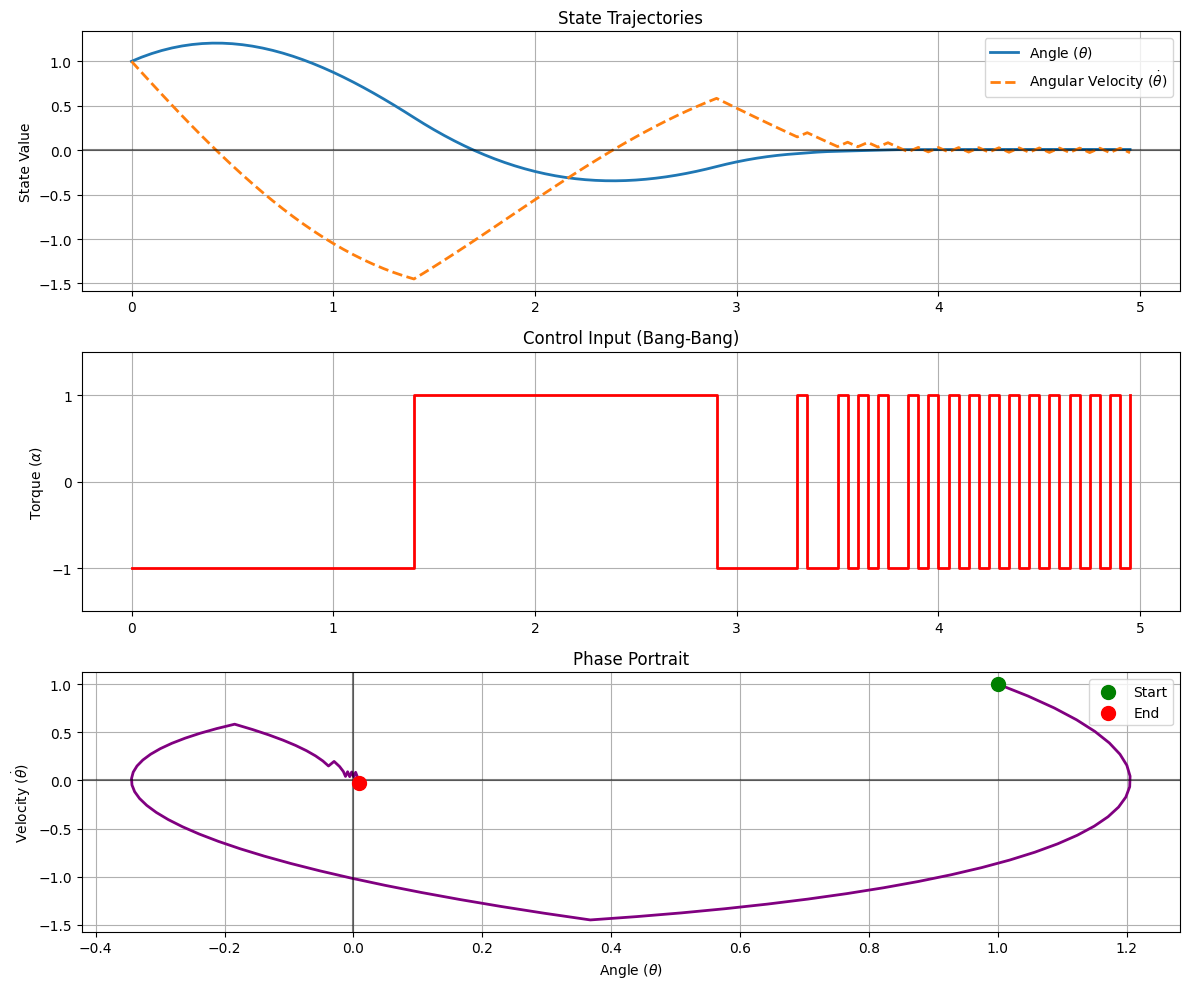

In [7]:
visualize_results(trained_model, env)